<a href="https://colab.research.google.com/github/aquapathos/MLLesson/blob/master/ATARI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 準備
- [pfrl](https://github.com/pfnet/pfrl)　[(GitHub)](https://github.com/pfnet/pfrl)

[atari wrapper](https://github.com/pfnet/pfrl/blob/master/pfrl/wrappers/atari_wrappers.py)を使うために導入

In [3]:
!apt-get update && apt-get install -qq  xvfb   < /dev/null > /dev/null
!pip install pfrl > /dev/null
!pip install gym-notebook-wrapper > /dev/null

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [2,162 kB]
Get:15 http://

# 注意　
ENV_NAMEとしては、名前に **NoFrameskip** を含むものを選ぶこと

- [OpenAI Gym の Atari Environment の命名規則と罠について](https://qiita.com/keisuke-nakata/items/141fc53f419b102d942c)

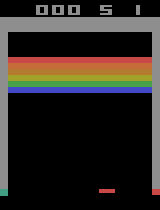

(210, 160, 3)


In [5]:
from google.colab.patches import cv2_imshow
ENV_NAME = 'BreakoutNoFrameskip-v0'
env=make_atari(ENV_NAME)
frame0 = env.reset()
cv2_imshow(frame0[:,:,::-1])
print(frame0.shape)

env=make_atari('BreakoutNoFrameskip-v0')　で (210,160,3) 形式の観測データが得られることがわかる。

なお、make_atari は4フレームおきに画像を取得する。

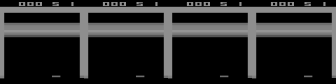

In [6]:
ENV_NAME = 'BreakoutNoFrameskip-v0'
env=make_atari(ENV_NAME)
env = wrap_deepmind(env)
canvas = np.zeros((84,4*84))
for i in range(4):
  canvas[:,84*i:84*i+84] = np.transpose(env.reset(),(0,1,2))[i]
cv2_imshow(canvas)


In [7]:
env.action_space.n

4

make_atari した env を wrap_deepmind() に通すことで、
- グレイ変換
- 84x84 にリサイズ
- ４ステップ分（4フレームごとに取り出したフレームを４つ）をひとまとめにして、
4チャネル×84×84というサイズのでータを観測データとして出力

してくれる。

In [8]:
import pfrl
import torch
import torch.nn as nn
import gym
import numpy
from pfrl import nn as pnn
from pfrl.initializers import init_chainer_default

In [9]:
ENV_NAME = 'BreakoutNoFrameskip-v0'

env=make_atari(ENV_NAME,max_frames = None)
print('observation space:', env.observation_space)
env.seed(np.random.seed())
env = wrap_deepmind(env,episode_life=False,
            clip_rewards=True,
            scale = True,
            flicker=False,
            frame_stack=True,)

print('observation space:', env.observation_space)
print('action space:', env.action_space)
obs = env.reset()
action = env.action_space.sample()
obs, r, done, info = env.step(action)
n_actions = env.action_space.n
print('next observation:', obs)
print('reward:', r)
print('done:', done)
print('info:', info)

observation space: Box(210, 160, 3)
observation space: Box(4, 84, 84)
action space: Discrete(4)
next observation: <pfrl.wrappers.atari_wrappers.LazyFrames object at 0x7f33cc7f0080>
reward: 0.0
done: False
info: {'ale.lives': 5}


# DoubleDQN

In [15]:

func = nn.Sequential(
    nn.Conv2d(4,32,8,4),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32,64,4,2),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64,64,3,1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Flatten(),    
    nn.Linear(7 * 7 * 64, 512),
    nn.ReLU(),
    nn.Linear(512, n_actions),
    pfrl.q_functions.DiscreteActionValueHead(),
)

func_S=nn.Sequential(
    nn.Conv2d(4,16,8,4),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16,32,4,2),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Flatten(),    
    nn.Linear(32*9*9, n_actions),
    pfrl.q_functions.DiscreteActionValueHead(),
)

# オプティマイザー
optimizer_A = torch.optim.Adam(func.parameters(), eps=1e-2)

optimizer_R = pfrl.optimizers.RMSpropEpsInsideSqrt(
        func.parameters(),
        lr=0.01,
        alpha=0.95,
        momentum=0.0,
        eps=1e-2,
        centered=True,
    )

In [11]:
gamma = 0.9
replay_buffer_size = 10 ** 3
gpu = 0  # 0番のGPU   -1 gpu を使わない

constantepsiron = 0.3 # .ConstantEpsilonGreedy用
final_epsilon = 0.1 # LinearDecayEpsilonGreedy用
final_exploration_frames = 1e5  # 100000 ε=0.1になるまでのステップ数

explorer1 = pfrl.explorers.ConstantEpsilonGreedy(
    epsilon=constantepsiron, random_action_func=env.action_space.sample)
replay_buffer = pfrl.replay_buffers.ReplayBuffer(capacity=replay_buffer_size)

explorer2 = pfrl.explorers.LinearDecayEpsilonGreedy(
            start_epsilon = 1.0, 
            end_epsilon = final_epsilon,
            decay_steps = final_exploration_frames,
            random_action_func = lambda: np.random.randint(n_actions))

def phi(x):
    return np.asarray(np.array(x), dtype=np.float32) 

agent = pfrl.agents.DoubleDQN(
    func_S,
    optimizer_R,
    replay_buffer,
    gamma,
    explorer = explorer2,
    replay_start_size=500,
    update_interval=1,
    target_update_interval=100,
    phi=phi,
    gpu=gpu,
)

# 学習の実行
1エピソード当たりの最高ステップ数を1000として、300エピソード学習させてみる

まず、func_S と optimizer_R の組み合わせで試す

In [17]:
%time
n_episodes = 300
max_episode_len = 1000
for i in range(1, n_episodes + 1):
    obs = env.reset()
    R = 0  # return (sum of rewards)
    t = 0  # time step
    while True:
        # Uncomment to watch the behavior in a GUI window
        # env.render()
        action = agent.act(obs)
        obs, reward, done, _ = env.step(action)
        R += reward
        t += 1
        reset = t == max_episode_len
        agent.observe(obs, reward, done, reset)
        if done or reset:
            break
    if i % 10 == 0:
        print('episode:', i, 'R:', R)
    if i % 50 == 0:
        print('statistics:', agent.get_statistics())
print('Finished.')

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 5.01 µs
episode: 10 R: 0.0
episode: 20 R: 1.0
episode: 30 R: 2.0
episode: 40 R: 0.0
episode: 50 R: 0.0
statistics: [('average_q', 0.2491998), ('average_loss', 0.033368001002818344), ('cumulative_steps', 72859), ('n_updates', 72360), ('rlen', 1000)]
episode: 60 R: 3.0
episode: 70 R: 1.0
episode: 80 R: 5.0
episode: 90 R: 5.0
episode: 100 R: 0.0
statistics: [('average_q', 0.28363454), ('average_loss', 0.032040671207942066), ('cumulative_steps', 84291), ('n_updates', 83792), ('rlen', 1000)]
episode: 110 R: 1.0
episode: 120 R: 4.0
episode: 130 R: 1.0
episode: 140 R: 0.0
episode: 150 R: 2.0
statistics: [('average_q', 0.32046252), ('average_loss', 0.02005550486035645), ('cumulative_steps', 97193), ('n_updates', 96694), ('rlen', 1000)]
episode: 160 R: 2.0
episode: 170 R: 4.0
episode: 180 R: 0.0
episode: 190 R: 2.0
episode: 200 R: 4.0
statistics: [('average_q', 0.33060864), ('average_loss', 0.013072890529292636), ('cumulative_steps

# 評価モード



In [19]:
with agent.eval_mode():
    for i in range(10):
        obs = env.reset()
        R = 0
        t = 0
        while True:
            # Uncomment to watch the behavior in a GUI window
            # env.render()
            action = agent.act(obs)
            obs, r, done, _ = env.step(action)
            R += r
            t += 1
            reset = t == max_episode_len
            agent.observe(obs, r, done, reset)
            if done or reset:
                break
        print('evaluation episode:', i, 'R:', R)

evaluation episode: 0 R: 0.0
evaluation episode: 1 R: 0.0
evaluation episode: 2 R: 0.0
evaluation episode: 3 R: 0.0
evaluation episode: 4 R: 0.0
evaluation episode: 5 R: 0.0
evaluation episode: 6 R: 0.0
evaluation episode: 7 R: 0.0
evaluation episode: 8 R: 0.0
evaluation episode: 9 R: 0.0


In [ ]:
with agent.eval_mode():
    for i in range(10):
        obs = env.reset()
        R = 0
        t = 0
        while True:
            # Uncomment to watch the behavior in a GUI window
            # env.render()
            action = agent.act(obs)
            obs, r, done, _ = env.step(action)
            R += r
            t += 1
            reset = t == max_episode_len
            agent.observe(obs, r, done, reset)
            if done or reset:
                break
        print('evaluation episode:', i, 'R:', R)

In [20]:
from google.colab import drive
drive.mount('/content/drive')
agent.save('/content/drive/My Drive/agent')

# 読み出しは、
# agent.load('/content/drive/My Drive/agent')

Mounted at /content/drive


In [ ]:
import logging
import sys
logging.basicConfig(level=logging.INFO, stream=sys.stdout, format='')

# 本番　func と optimizer_Aの組み合わせ
agent_S = pfrl.agents.DoubleDQN(
    func,
    optimizer_A,
    replay_buffer,
    gamma,
    explorer = explorer2,
    replay_start_size=500,
    update_interval=1,
    target_update_interval=100,
    phi=phi,
    gpu=gpu,
)

pfrl.experiments.train_agent_with_evaluation(
    agent,
    env,
    steps=2000,           # Train the agent for 2000 steps
    eval_n_steps=None,       # We evaluate for episodes, not time
    eval_n_episodes=10,       # 10 episodes are sampled for each evaluation
    train_max_episode_len=200,  # Maximum length of each episode
    eval_interval=1000,   # Evaluate the agent after every 1000 steps
    outdir='/content/drive/My Drive/agent',      # Save everything to 'result' directory
)